In [5]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Estimating frequencies with ABCD matrices

In [6]:
n_jct = 24
lj = 15/n_jct
cj = 1/(lj*(15*2*np.pi)**2)
cg = 1e-7
ct = 1/(7.5*(4*2*np.pi)**2)

rg = np.inf
rjp = np.inf
rjs = 0
rt = np.inf

In [7]:
zs = lambda w, lj, cj: 1j*lj*w/(1-lj*cj*w**2)
yg = lambda w, cg: 1j*cg*w
zt = lambda w, ct: 1/(1j*ct*w)
#gamma = lambda w, lj, cj, cg: np.arccos(zs(w, lj, cj)*yg(w, cg)/2+1)
gamma = lambda w, lj, cj, cg: -1j*np.sqrt(zs(w, lj, cj)*yg(w, cg))
#zl = lambda w, lj, cj, cg: np.sqrt(zs(w, lj, cj)/yg(w, cg)*np.exp(1j*gamma(w, lj, cj, cg)))
zl = lambda w, lj, cj, cg: np.sqrt(zs(w, lj, cj)/yg(w, cg))

C:\Users\rroussea\AppData\Local\Temp\ipykernel_13920\2300706387.py:1: RuntimeWarning: divide by zero encountered in true_divide
  zs = lambda w, lj, cj: 1j*lj*w/(1-lj*cj*w**2)
C:\Users\rroussea\AppData\Local\Temp\ipykernel_13920\2300706387.py:1: RuntimeWarning: invalid value encountered in true_divide
  zs = lambda w, lj, cj: 1j*lj*w/(1-lj*cj*w**2)
C:\Users\rroussea\AppData\Local\Temp\ipykernel_13920\2300706387.py:5: RuntimeWarning: invalid value encountered in multiply
  gamma = lambda w, lj, cj, cg: -1j*np.sqrt(zs(w, lj, cj)*yg(w, cg))
C:\Users\rroussea\AppData\Local\Temp\ipykernel_13920\2300706387.py:7: RuntimeWarning: invalid value encountered in true_divide
  zl = lambda w, lj, cj, cg: np.sqrt(zs(w, lj, cj)/yg(w, cg))
C:\Users\rroussea\AppData\Local\Temp\ipykernel_13920\2300706387.py:3: RuntimeWarning: divide by zero encountered in true_divide
  zt = lambda w, ct: 1/(1j*ct*w)
C:\Users\rroussea\AppData\Local\Temp\ipykernel_13920\2300706387.py:3: RuntimeWarning: invalid value encoun

0.0 0.0


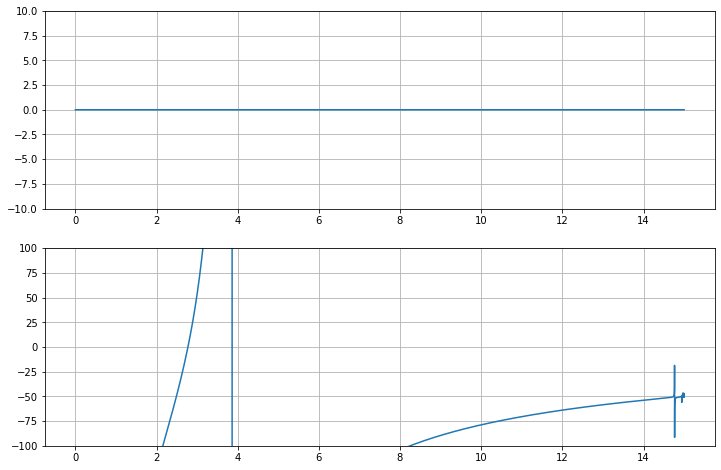

In [9]:
ws = np.linspace(0,1/np.sqrt(lj*cj)/2/np.pi,10000)*2*np.pi
#ws = np.linspace(0,17.5,100000)*2*np.pi
gam = gamma(ws, lj, cj, cg)
zl_v = zl(ws, lj, cj, cg)
yt_v = 1/zt(ws,ct)
v_in = np.cosh(1j*gam*n_jct)+zl_v*yt_v*np.sinh(1j*gam*n_jct)
i_in = 2*yt_v*np.cosh(1j*gam*n_jct)+(zl_v*yt_v**2+1/zl_v)*np.sinh(1j*gam*n_jct)
z_in = v_in/i_in
ylim = 1e3

print(np.nanmin(np.real(z_in)), np.nanmax(np.real(z_in)))
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(ws/2/np.pi,np.real(z_in))
axs[1].plot(ws/2/np.pi,np.imag(z_in))

axs[0].grid()
axs[1].grid()
axs[0].set_ylim([-10,10])
axs[1].set_ylim([-100,100])
plt.show()

# With buffer and memory

In [10]:
f_p =  15

n_jct_memory = 25
L_memory = 15
lj_mem = L_memory/n_jct_memory
cj_mem = 1/(lj_mem*(f_p*2*np.pi)**2)
#ct_mem = 8.358e-5
ct_mem = 1e-4

L_ats = 4

n_jct_buffer = 9
L_buffer = 3.5
lj_buf = L_buffer/n_jct_buffer
cj_buf = 1/(lj_buf*(f_p*2*np.pi)**2)
#ct_buf = 6.8318e-5
ct_buf = 9.2e-5

cg = 1e-9

In [11]:
def transmission_serie(Z):
    return np.array([[1, Z],
                     [0, 1]])

def transmission_shunt(Y):
    return np.array([[1, 0],
                     [Y, 1]])

def transmission_line(_zl, _gamma, _n_jct):
    return np.array([[np.cosh(1j*_gamma*_n_jct), _zl*np.sinh(1j*_gamma*_n_jct)],
                     [1/_zl*np.sinh(1j*_gamma*_n_jct),np.cosh(1j*_gamma*_n_jct)]])

zs = lambda _w, _lj, _cj: 1j*lj*_w/(1-_lj*_cj*_w**2)

In [12]:
def z_in_perf(w):
    zs_mem = 1j*L_memory*w
    yt_mem = 1j*ct_mem*w
    y_ats = 1/(1j*L_ats/5*w)
    zs_buf = 1j*L_buffer*w
    yt_buf = 1j*ct_buf*w

    mat_sh_mem = transmission_shunt(yt_mem)
    mat_lin_mem = transmission_serie(zs_mem)
    mat_sh_ats = transmission_shunt(y_ats)
    mat_lin_buf = transmission_serie(zs_buf)
    mat_sh_buf = transmission_shunt(yt_buf)

    pdt = np.array([[1],[0]])
    for mat in [mat_sh_mem,mat_lin_mem,mat_sh_ats,mat_lin_buf,mat_sh_buf][::-1]:
        pdt = np.dot(mat,pdt)

    return np.imag(pdt[0]/pdt[1])

In [13]:
def z_in_trans_continue(w):
    yg = 1j*cg*w

    zs_mem = zs(w, lj_mem, cj_mem)
    yt_mem = 1j*ct_mem*w
    gamma_mem = -1j*np.sqrt(zs_mem*yg)
    zl_mem = np.sqrt(zs_mem/yg)

    y_ats = 1/(1j*L_ats*w)

    zs_buf = zs(w, lj_buf, cj_buf)
    yt_buf = 1j*ct_buf*w
    gamma_buf = -1j*np.sqrt(zs_buf*yg)
    zl_buf = np.sqrt(zs_buf/yg)

    mat_sh_mem = transmission_shunt(yt_mem)
    mat_lin_mem = transmission_line(zl_mem,gamma_mem,n_jct_memory)
    mat_sh_ats = transmission_shunt(y_ats)
    mat_lin_buf = transmission_line(zl_buf,gamma_buf,n_jct_buffer)
    mat_sh_buf = transmission_shunt(yt_buf)

    pdt = np.array([[1],[0]])
    for mat in [mat_sh_mem,mat_lin_mem,mat_sh_ats,mat_lin_buf,mat_sh_buf][::-1]:
        pdt = np.dot(mat,pdt)

    return np.imag(pdt[0]/pdt[1])

In [14]:
def z_in_trans_discret(w):
    yg = 1j*cg*w

    zs_mem = zs(w, lj_mem, cj_mem)
    yt_mem = 1j*ct_mem*w
    gamma_mem = np.arccos(zs_mem*yg/2+1)
    zl_mem = np.sqrt(zs_mem/yg*np.exp(1j*gamma_mem))


    y_ats = 1/(1j*L_ats*w)

    zs_buf = zs(w, lj_buf, cj_buf)
    yt_buf = 1j*ct_buf*w
    gamma_buf = np.arccos(zs_buf*yg/2+1)
    zl_buf = np.sqrt(zs_buf/yg*np.exp(1j*gamma_buf))

    mat_sh_mem = transmission_shunt(yt_mem)
    mat_lin_mem = transmission_line(zl_mem,gamma_mem,n_jct_memory)
    mat_sh_ats = transmission_shunt(y_ats)
    mat_lin_buf = transmission_line(zl_buf,gamma_buf,n_jct_buffer)
    mat_sh_buf = transmission_shunt(yt_buf)

    pdt = np.array([[1],[0]])
    for mat in [mat_sh_mem,mat_lin_mem,mat_sh_ats,mat_lin_buf,mat_sh_buf][::-1]:
        pdt = np.dot(mat,pdt)

    return np.imag(pdt[0]/pdt[1])

In [15]:
ws = np.linspace(0,14,10000)[1:-1]*2*np.pi
z_in_v_perf, z_in_v_cont, z_in_v_discr =[], [], []
for w in tqdm(ws):
    z_in_v_perf.append(z_in_perf(w))
    z_in_v_cont.append(z_in_trans_continue(w))
    z_in_v_discr.append(z_in_trans_discret(w))

100%|██████████| 9998/9998 [00:01<00:00, 6776.09it/s]


In [16]:
def get_poles(vals, threshold= 15):
    vals = np.array(vals)
    sgn_multi = np.sign(vals)
    eigen_ind_multi = [ind for ind, test in enumerate(sgn_multi[:-1] * sgn_multi[1:] == -1) if test]
    return [ws[ind]/2/np.pi for ind in eigen_ind_multi if abs(vals[ind-1] - vals[ind])>threshold]

Perfect inductances [3.9973997399739973, 8.03960396039604, 8.052205220522051]
Continuous model [3.419141914191419, 5.443744374437443]
Discrete model [3.419141914191419, 5.443744374437443]


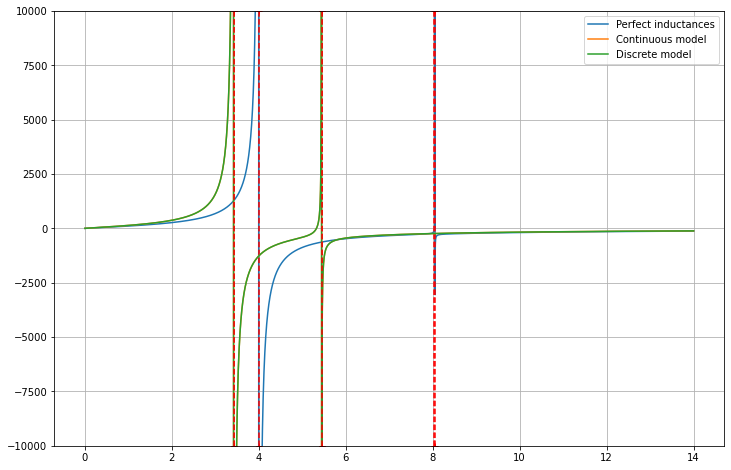

In [17]:
z_work_l = [z_in_v_perf, z_in_v_cont, z_in_v_discr]
z_names = ["Perfect inductances", "Continuous model", "Discrete model"]

fig,axs = plt.subplots(figsize=(12,8))
ylim = 1e4
for z_w, name in zip(z_work_l, z_names):
    eigen_f_multi = get_poles(z_w)
    print(name, eigen_f_multi)

    axs.plot(ws/2/np.pi,z_w, label = name)
    for f in eigen_f_multi:
        axs.plot([f,f],[-ylim,ylim],"+--",color="red")

axs.grid()
axs.set_ylim([-ylim,ylim])
plt.legend()
plt.show()

## All treated like a transmission line

In [18]:
f_p =  15

n_jct_memory = 25
L_memory = 15
lj_mem = L_memory/n_jct_memory
cj_mem = 1/(lj_mem*(f_p*2*np.pi)**2)
#ct_mem = 8.358e-5
ct_mem = 1e-4

n_jct_ats = 5
L_ats = 4
lj_ats = L_ats/n_jct_ats
cj_ats = 1/(lj_ats*(f_p*2*np.pi)**2)

n_jct_buffer = 9
L_buffer = 3.5
lj_buf = L_buffer/n_jct_buffer
cj_buf = 1/(lj_buf*(f_p*2*np.pi)**2)
#ct_buf = 6.8318e-5
ct_buf = 9.2e-5

cg = 1e-9

In [19]:
def transmission_serie(Z):
    return np.array([[1, Z],
                     [0, 1]])

def transmission_shunt(Y):
    return np.array([[1, 0],
                     [Y, 1]])

def transmission_line(_zl, _gamma, _n_jct):
    return np.array([[np.cosh(1j*_gamma*_n_jct), _zl*np.sinh(1j*_gamma*_n_jct)],
                     [1/_zl*np.sinh(1j*_gamma*_n_jct),np.cosh(1j*_gamma*_n_jct)]])

def shunt_ats(_zl, _gamma, _n_jct, _y_ats):
    y = 1/np.tanh(1j*_gamma*_n_jct)/_zl + 2*_y_ats
    #y = np.tanh(1j*_gamma*_n_jct)/_zl + 2*_y_ats
    return np.array([[1, 0],
                     [y, 1]])

zs = lambda _w, _lj, _cj: 1j*lj*_w/(1-_lj*_cj*_w**2)

In [20]:
def z_in_perf(w):
    zs_mem = 1j*L_memory*w
    yt_mem = 1j*ct_mem*w
    L_ats_eq = L_ats/5
    y_ats = 1/(1j*L_ats_eq*w)
    zs_buf = 1j*L_buffer*w
    yt_buf = 1j*ct_buf*w

    mat_sh_mem = transmission_shunt(yt_mem)
    mat_lin_mem = transmission_serie(zs_mem)
    mat_sh_ats = transmission_shunt(y_ats)
    mat_lin_buf = transmission_serie(zs_buf)
    mat_sh_buf = transmission_shunt(yt_buf)

    pdt = np.array([[1],[0]])
    for mat in [mat_sh_mem,mat_lin_mem,mat_sh_ats,mat_lin_buf,mat_sh_buf][::-1]:
        pdt = np.dot(mat,pdt)

    return np.imag(pdt[0]/pdt[1])

In [21]:
def z_in_all_trans_continue(w):
    yg = 1j*cg*w

    zs_mem = zs(w, lj_mem, cj_mem)
    yt_mem = 1j*ct_mem*w
    gamma_mem = -1j*np.sqrt(zs_mem*yg)
    zl_mem = np.sqrt(zs_mem/yg)

    zs_ats = zs(w,lj_ats,cj_ats)
    gamma_ats = -1j*np.sqrt(zs_ats*yg)
    zl_ats = np.sqrt(zs_ats*yg)
    y_ats = 2/(1j*L_ats*w)

    zs_buf = zs(w, lj_buf, cj_buf)
    yt_buf = 1j*ct_buf*w
    gamma_buf = -1j*np.sqrt(zs_buf*yg)
    zl_buf = np.sqrt(zs_buf/yg)

    mat_sh_mem = transmission_shunt(yt_mem)
    mat_lin_mem = transmission_line(zl_mem,gamma_mem,n_jct_memory)
    mat_sh_ats = shunt_ats(zl_ats,gamma_ats,n_jct_ats,y_ats)
    mat_lin_buf = transmission_line(zl_buf,gamma_buf,n_jct_buffer)
    mat_sh_buf = transmission_shunt(yt_buf)

    pdt = np.array([[1],[0]])
    for mat in [mat_sh_mem,mat_lin_mem,mat_sh_ats,mat_lin_buf,mat_sh_buf][::-1]:
        pdt = np.dot(mat,pdt)

    return np.imag(pdt[0]/pdt[1])

In [22]:
def z_in_all_trans_discret(w):
    yg = 1j*cg*w

    zs_mem = zs(w, lj_mem, cj_mem)
    yt_mem = 1j*ct_mem*w
    gamma_mem = np.arccos(zs_mem*yg/2+1)
    zl_mem = np.sqrt(zs_mem/yg*np.exp(1j*gamma_mem))


    zs_ats = zs(w,lj_ats,cj_ats)
    gamma_ats = np.arccos(zs_ats*yg/2+1)
    zl_ats = np.sqrt(zs_ats/yg*np.exp(1j*gamma_ats))
    y_ats = 2/(1j*L_ats*w)

    zs_buf = zs(w, lj_buf, cj_buf)
    yt_buf = 1j*ct_buf*w
    gamma_buf = np.arccos(zs_buf*yg/2+1)
    zl_buf = np.sqrt(zs_buf/yg*np.exp(1j*gamma_buf))

    mat_sh_mem = transmission_shunt(yt_mem)
    mat_lin_mem = transmission_line(zl_mem,gamma_mem,n_jct_memory)
    mat_sh_ats = shunt_ats(zl_ats,gamma_ats,n_jct_ats,y_ats)
    mat_lin_buf = transmission_line(zl_buf,gamma_buf,n_jct_buffer)
    mat_sh_buf = transmission_shunt(yt_buf)

    pdt = np.array([[1],[0]])
    for mat in [mat_sh_mem,mat_lin_mem,mat_sh_ats,mat_lin_buf,mat_sh_buf][::-1]:
        pdt = np.dot(mat,pdt)

    return np.imag(pdt[0]/pdt[1])

In [23]:
ws = np.linspace(0,14,100000)[1:-1]*2*np.pi
z_in_v_perf, z_in_v_cont, z_in_v_discr =[], [], []
for w in tqdm(ws):
    z_in_v_perf.append(z_in_perf(w))
    z_in_v_cont.append(z_in_all_trans_continue(w))
    z_in_v_discr.append(z_in_all_trans_discret(w))

100%|██████████| 99998/99998 [00:13<00:00, 7536.39it/s]


In [24]:
def get_poles(vals, threshold= 10):
    vals = np.array(vals)
    sgn_multi = np.sign(vals)
    eigen_ind_multi = [ind for ind, test in enumerate(sgn_multi[:-1] * sgn_multi[1:] == -1) if test]
    return [ws[ind]/2/np.pi for ind in eigen_ind_multi if abs(vals[ind-1] - vals[ind])>threshold]

Perfect inductances [3.99759997599976, 8.052320523205232]
Discrete model [3.8883988839888395]
Continuous model [3.802578025780258, 6.071860718607186]


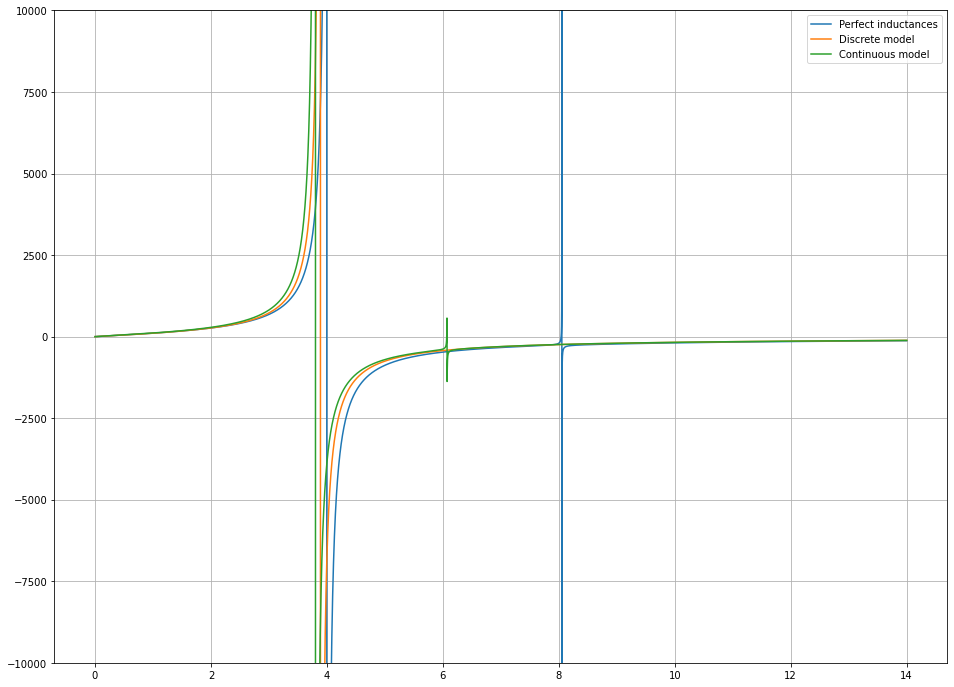

In [25]:
z_work_l = [z_in_v_perf, z_in_v_cont, z_in_v_discr]
z_names = ["Perfect inductances", "Discrete model", "Continuous model"]

fig,axs = plt.subplots(figsize=(16,12))
ylim = 1e4
for z_w, name in zip(z_work_l, z_names):
    eigen_f_multi = get_poles(z_w)
    print(name, eigen_f_multi)

    axs.plot(ws/2/np.pi,z_w, label = name)
    # for f in eigen_f_multi:
    #     axs.plot([f,f],[-ylim,ylim],"+--",color="red")

axs.grid()
axs.set_ylim([-ylim,ylim])
plt.legend()
plt.show()